# Classical Anomaly Detection

In [242]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from sklearn.datasets import make_blobs, make_checkerboard, make_moons

## K-means

1. Validate the number of clusters with average silhouette score
2. Classify anomalies based on distance to cluster centroid

In [14]:
SEED = 71

def get_elbow_curve(X: np.ndarray, start: int, stop: int, step: int = 1):

    ''' 
    Determine the silhouette score elbow curve for K-Means clustering on X for k in the range [start, stop]
    '''

    k_range = np.arange(start, stop, step)
    score = []

    for k in k_range:

        kmeans = KMeans(n_clusters=k, random_state=SEED)
        y = kmeans.fit_predict(X)
        score.append(silhouette_score(X, y))

    
    fig, ax = plt.subplots()

    ax.plot(k_range, score)
    ax.set_xlabel('# clusters')
    ax.set_ylabel('avg silhouette score')

    return fig, ax


def train_kmeans(X: np.ndarray, k: int):
    ''' 
    Get a trained kmeans model and mean and stdev of the centroid distance.
    Ideally only train on inliers to get better performance
    '''

    kmeans = KMeans(n_clusters = k, random_state=SEED)
    y = kmeans.fit_predict(X)
    dist = np.min(kmeans.transform(X), axis=1)

    cluster_params = []

    # get mean and standard deviation of the intra-cluster distance
    for i in range(k):

        cluster_params.append((np.mean(dist[y == i]), np.std(dist[y == i])))

    return kmeans, cluster_params


def get_kmeans_outliers(X_train: np.ndarray, X_test: np.ndarray, k: int, n_std: float = 3):

    model, params = train_kmeans(X_train, k)

    # get labels and distance to centroid for every test sample
    labs = model.predict(X_test)
    min_dist = np.min(model.transform(X_test), axis=1)
    
    # threshold all test values based on the parameters of their assigned cluster
    is_outlier = [min_dist[i] > params[labs[i]][0] + n_std * params[labs[i]][1] for i in range(len(labs))]

    return is_outlier

In [40]:
# test on some random synthetic data

X,y  = make_blobs(n_samples=500, n_features=5, centers = 7)

n_split = int(np.ceil(0.05*len(X)))
split_idx = np.random.randint(0,len(X), n_split)
X_test = X[split_idx]
X_train = X[[i for i in range(len(X)) if i not in split_idx]]

n_outliers = 50
rng = np.random.RandomState(SEED)
X_test = np.concatenate([rng.uniform(low=np.min(X), high=np.max(X), size=(n_outliers, 5)), X_test], axis = 0)

is_ol = get_kmeans_outliers(X_train, X_test, 7)

## Isolation Forest

In [140]:
def train_iforest(X: np.ndarray, n_estimators: int):

    forest = IsolationForest(n_estimators= n_estimators, random_state=SEED)
    forest.fit(X)

    return forest


def get_iforest_outliers(X_train: np.ndarray, X_test: np.ndarray, n_estimators: int):

    model = train_iforest(X_train, n_estimators)
    is_outlier = model.predict(X_test) == -1

    return is_outlier

In [157]:
is_ol = get_iforest_outliers(X_train, X_test, 200)

In [161]:
np.arange(len(is_ol))[is_ol]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 55,
       56, 63, 64, 73])

## Local Outlier Factor

In [169]:
def train_lof(X: np.ndarray, n_neighbors: int):
    ''' 
    Train LOF on inliers only
    '''

    lof = LocalOutlierFactor(n_neighbors, novelty=True)
    lof.fit(X)

    return lof


def get_lof_outliers(X_train: np.ndarray, X_test: np.ndarray, n_neighbors: int):

    model = train_lof(X_train, n_neighbors)
    is_outlier = model.predict(X_test) == -1

    return is_outlier

In [166]:
is_ol = get_lof_outliers(X_train, X_test, 30)

In [167]:
np.arange(len(is_ol))[is_ol]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

## DBSCAN

In [244]:
def get_DBSCAN_outliers(X: np.ndarray, eps: float):

    model = DBSCAN(eps)
    y = model.fit_predict(X)

    is_outlier = y == -1
    
    return is_outlier

## Manual Feature Engineering 

In [194]:
def aggregate_df(X: np.ndarray, t: float):
    ''' 
    Calculate moving average of the rows of X with parameter t.

    Parameters:
    ------------
    X: np.ndarray
        The data over which to calculate the EWMA. Must be ordered by time.

    t: float
        Parameter to use for weighing the old and new terms in EMWA

    Returns:
    --------
    mov_avg: np.ndarray
        The moving average of every column of X at the last time point
    '''

    mov_avg = X[0]

    for x in X[1:]:

        mov_avg = (1-t) * mov_avg + t * x

    return mov_avg


def get_moving_avg(X: pd.DataFrame, time_key: str, group_key: str, t: float):
    
    X = X.groupby(group_key).apply(lambda x: aggregate_df(x.sort_values(by=time_key, ascending = True).loc[:, x.columns != time_key].to_numpy(), t))

    return X

In [227]:
# test on ubs data

PATH = '~/Documents/ETH/FS2024/datathon24/skylab_instagram_datathon_dataset.csv'
df = pd.read_csv(PATH, sep = ';')

In [303]:
def video_to_picture_ratio(df, videos_col, pictures_col):
    df['video_picture_ratio'] = df[videos_col] / df[pictures_col]
    return df


def calculate_rolling_average_per_brand(data, brand_column, window_size=7):
    """
    Calculate the rolling average of 'engagement' for each brand in a DataFrame.

    Parameters:
        data (pd.DataFrame): The DataFrame containing the data.
        brand_column (str): The column name which identifies the brand.
        window_size (int): The number of observations used for calculating the rolling average.

    Returns:
        pd.DataFrame: The DataFrame with a new column for the rolling average of 'engagement' calculated per brand.
    """
    # Group by brand and calculate rolling average within each group
    data['rolling_avg_engagement'] = data.groupby(brand_column)['engagement'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    return data


def calculate_exponential_moving_average_per_brand(data, brand_column, span=7):
    """
    Calculate the exponential moving average of 'engagement' for each brand in a DataFrame.

    Parameters:
        data (pd.DataFrame): The DataFrame containing the data.
        brand_column (str): The column name which identifies the brand.
        span (int): The decay in terms of the span of the exponential window.

    Returns:
        pd.DataFrame: The DataFrame with a new column for the exponential moving average of 'engagement' calculated per brand.
    """
    # Group by brand and calculate EMA within each group
    data['ewma_engagement'] = data.groupby(brand_column)['engagement'].transform(lambda x: x.ewm(span=span, adjust=False).mean())
    return data


def calculate_brand_wise_growth_rates(data, column_names, brand_column):
    """
    Calculate the growth rate for specified columns in a DataFrame, grouped by brand.
    Replace NaN values with 0 where growth rate cannot be calculated.

    Parameters:
        data (pd.DataFrame): The DataFrame containing the data.
        column_names (list of str): A list of column names to calculate the growth rate.
        brand_column (str): The column name which identifies the brand.

    Returns:
        pd.DataFrame: The DataFrame with new columns for each specified column's growth rate, calculated for each brand and NaN replaced by 0.
    """
    for column in column_names:
        # Calculate growth rate within each brand group
        data[f'growth_rate_{column}'] = data.groupby(brand_column)[column].pct_change() * 100
        # Replace NaN values with 0
        data[f'growth_rate_{column}'].fillna(0, inplace=True)
    return data

def calculate_brand_rolling_statistics(data, column_name, brand_column, window_size=7):
    """
    Calculate rolling statistics for a specified column in a DataFrame, grouped by brand,
    and replace NaN values with 0.

    Parameters:
        data (pd.DataFrame): The DataFrame containing the data.
        column_name (str): The column name to calculate rolling statistics.
        brand_column (str): The column name which identifies the brand.
        window_size (int): The number of observations used for calculating the rolling statistic.

    Returns:
        pd.DataFrame: The DataFrame with new columns for each rolling statistic of the specified column, calculated for each brand.
    """
    grouped = data.groupby(brand_column)[column_name]
    data[f'{column_name}_rolling_min'] = grouped.transform(lambda x: x.rolling(window=window_size, min_periods=1).min()).fillna(0)
    data[f'{column_name}_rolling_max'] = grouped.transform(lambda x: x.rolling(window=window_size, min_periods=1).max()).fillna(0)
    data[f'{column_name}_rolling_std'] = grouped.transform(lambda x: x.rolling(window=window_size, min_periods=1).std()).fillna(0)

    return data

def create_brand_lag_features(data, column_name, brand_column, lag_periods):
    """
    Create lag features for a specified column in a DataFrame, grouped by brand,
    and replace NaN values with 0.

    Parameters:
        data (pd.DataFrame): The DataFrame containing the data.
        column_name (str): The column name to create lag features for.
        brand_column (str): The column name which identifies the brand.
        lag_periods (int): The number of lag periods.

    Returns:
        pd.DataFrame: The DataFrame with new columns for each lag feature of the specified column, calculated for each brand.
    """
    for i in range(1, lag_periods + 1):
        data[f'{column_name}_lag_{i}'] = data.groupby(brand_column)[column_name].shift(i).fillna(0)

    return data




def preprocess_data(df, missing_values_cutoff=0.7, test_fraction=0.2):

    df = df.drop(columns=["period", "calculation_type", "compset", "compset_group", "legal_entity_name", "ultimate_parent_legal_entity_name", "primary_exchange_name"])
    df["period_end_date"] = pd.to_datetime(df["period_end_date"])

    df = df.rename(columns={'business_entity_doing_business_as_name': 'brand', 'period_end_date': 'date'})

    df = df[df['brand'] != "All Brands"]
    df = df[df['brand'] != "Boca"]
    df = df[df['brand'] != "Bulgari Beauty"]

    df = df.groupby(['brand', 'date']).first().reset_index()

    def correct_country_name(name):
        country_map = {
            "Hong Kong": "China",
            "China;Hong Kong": "China",
            ";France": "France",
            ";": None,
            "Belgium;": "Belgium"
        }
        if name in country_map.keys():
            return country_map[name]
        return name

    df['domicile_country_name'] = df['domicile_country_name'].apply(correct_country_name)


    categorical_features = ["domicile_country_name"]
    for feature in categorical_features:
        df = pd.get_dummies(df, columns=[feature], prefix=feature, dummy_na=True, dtype=int)

    # TODO: remove bad data
    na_frac = df[['brand', 'followers', 'pictures',
        'videos', 'comments', 'likes']].groupby('brand').apply(lambda x: x.iloc[:,1:].isna().sum()/len(x))

    bad_brands = list(na_frac[na_frac.max(axis=1) > missing_values_cutoff].index)

    df = df[~df['brand'].isin(bad_brands)]


    # TODO: add additional features
    df['engagement'] = df['comments'] + df['likes']
    df['engagement_rate'] = df['engagement']/df['followers']
    df['engagement_rate_per_post'] =  df['engagement_rate']/(df['videos'] + df['pictures'])


    df = video_to_picture_ratio(df, "videos", "pictures")
    df = calculate_rolling_average_per_brand(df, "brand", window_size=4)
    df = calculate_exponential_moving_average_per_brand(df, "brand", span=4)
    df = calculate_brand_wise_growth_rates(df, ["comments", "likes", "followers", "pictures", "videos"], "brand")
    for c in ["comments", "likes", "followers", "pictures", "videos"]:
        df = calculate_brand_rolling_statistics(df, c, "brand", window_size=4)
        df = create_brand_lag_features(df, c, "brand", 4)

    
    # Step 1: Sort the dataframe by time
    df_sorted = df.sort_values(by='date')

    # Step 2: Group the dataframe by 'Brand'
    grouped = df_sorted.groupby('brand')

    # Step 3: Define an empty dataframe for train and test sets
    train_df = pd.DataFrame(columns=df.columns)  # Columns same as original dataframe
    test_df = pd.DataFrame(columns=df.columns)   # Columns same as original dataframe

    # Step 4: Iterate over each group and split into train and test sets
    for _, group in grouped:
        n_rows = len(group)
        n_test = int(test_fraction * n_rows)  # 20% of rows for test set

        # Add last 20% of rows to test set
        test_df = pd.concat([test_df, group.iloc[-n_test:]])

        # Add remaining rows to train set
        train_df = pd.concat([train_df, group.iloc[:-n_test]])

    # Step 5: Reset index for both train and test dataframes
    train_df.reset_index(drop=True, inplace=True)
    test_df.reset_index(drop=True, inplace=True)


    # TODO: normalize values

    normalize_cols = [c for c in train_df.columns if c not in ['brand', 'date'] and not c.startswith("domicile_country_name")]
    for col in normalize_cols:
        m = train_df[col].mean()
        s = train_df[col].std()
        train_df[col] = (train_df[col] - m)/s
        test_df[col] = (test_df[col] - m)/s


    # TODO: impute missing values
  
    # TODO: impute missing values
    train_df = train_df.groupby('brand').apply(lambda group: group.fillna(method='ffill'))
    train_df = train_df.reset_index(drop=True)

    train_df = train_df.groupby('brand').apply(lambda group: group.fillna(method='bfill'))
    train_df = train_df.reset_index(drop=True)


    test_df = test_df.groupby('brand').apply(lambda group: group.fillna(method='ffill'))
    test_df = test_df.reset_index(drop=True)

    test_df = test_df.groupby('brand').apply(lambda group: group.fillna(method='bfill'))
    test_df = test_df.reset_index(drop=True)

    return train_df, test_df

In [304]:
df_train, df_test = preprocess_data(df)

/var/folders/xw/fn_947n13s74lq45rlqjgn780000gn/T/ipykernel_3984/3332805623.py:137: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'videos', 'comments', 'likes']].groupby('brand').apply(lambda x: x.iloc[:,1:].isna().sum()/len(x))
/var/folders/xw/fn_947n13s74lq45rlqjgn780000gn/T/ipykernel_3984/3332805623.py:55: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[f'growth_rate_{column}'] = data.groupby(brand_column)[column].pct_change() * 100
/var/folders/xw/fn_947n13s74lq45rlqjgn780000gn/T/ipyker

In [245]:
cols_rel = ['brand', 'date', 'followers', 'pictures', 'videos', 'comments', 'likes']#, 'engagement', 'engagement_rate']

df_train_red = df_train.loc[:,df_train.columns.isin(cols_rel)]

In [254]:
df_avg = get_moving_avg(df_train_red, 'date', 'brand', 0.3)

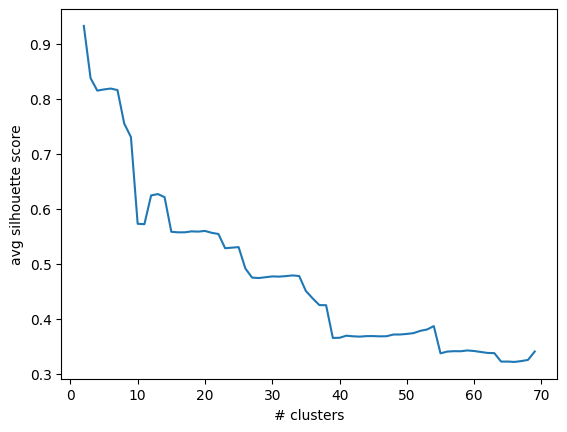

In [255]:
get_elbow_curve(np.array(df_avg.to_list()), start = 2, stop = 70)
labs_kmeans = get_kmeans_outliers(np.array(df_avg.to_list()), np.array(df_avg.to_list()), 8)
labs_if = get_iforest_outliers(np.array(df_avg.to_list()), np.array(df_avg.to_list()), 100)
labs_dbscan = get_DBSCAN_outliers(np.array(df_avg.to_list()), 0.4)

In [256]:
def plot_2D(X: np.ndarray, c = None):

    ''' 
    Super simple plotting function
    '''

    pca = PCA(2, random_state = SEED)
    X = pca.fit_transform(X)

    plt.scatter(X[:,0], X[:,1], c = c, s=3)
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')

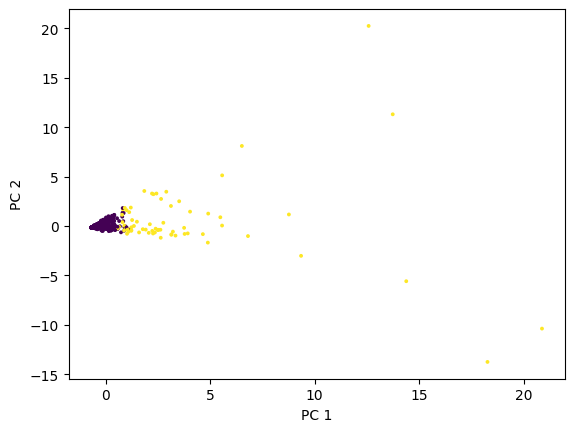

In [257]:
plot_2D(np.array(df_avg.to_list()), labs_if)

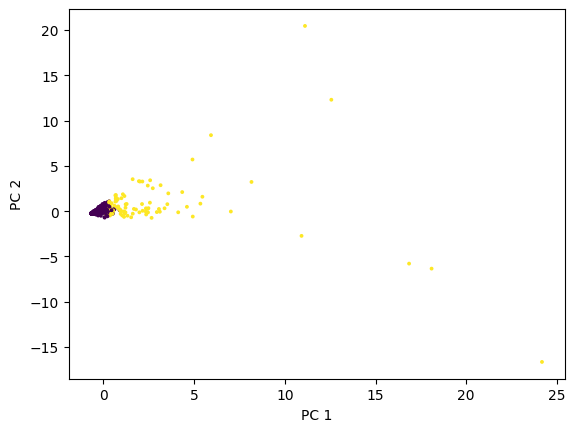

In [253]:
plot_2D(np.array(df_avg.to_list()), labs_dbscan)

In [ ]:
plot_2D(np.array(df_avg.to_list()), labs_dbscan)

## Validate with "ground truth" future values

In [305]:
lab_test = df_test.groupby('brand').apply(lambda x: x.sort_values(by = 'date').engagement_rate_per_post.iloc[-1])

/var/folders/xw/fn_947n13s74lq45rlqjgn780000gn/T/ipykernel_3984/1215658423.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lab_test = df_test.groupby('brand').apply(lambda x: x.sort_values(by = 'date').engagement_rate_per_post.iloc[-1])


In [319]:
df_test_avg = get_moving_avg(df_test.loc[:,cols_rel], 'date', 'brand', 0.3)

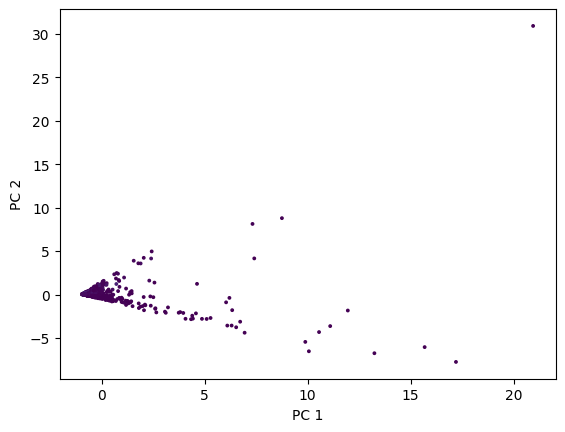

In [329]:
plot_2D(np.array(df_test_avg.to_list()), lab_test.to_numpy())

<Axes: >

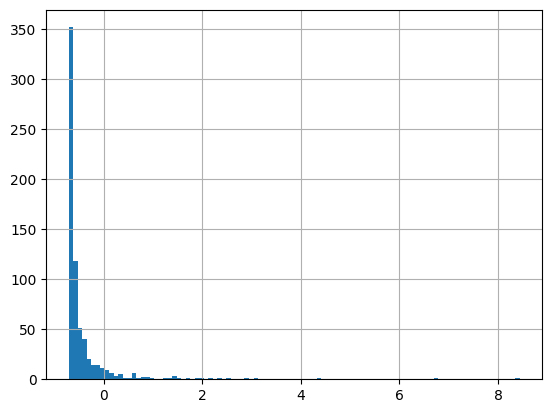

In [295]:
plot_2D(df_test)

## Anomaly detection on LSTM embeddings

In [330]:
embedding = np.loadtxt('embeddings_2layer.txt')
labels = np.loadtxt('labels_2layer.txt')

In [355]:
msk = ~np.logical_or(np.any(np.isnan(embedding), axis=1), np.isnan(labels))

embedding[msk]
labels[msk]

array([-0.42790605, -0.43486572, -0.44186544, ..., -0.67474162,
       -0.67397985, -0.67455877])

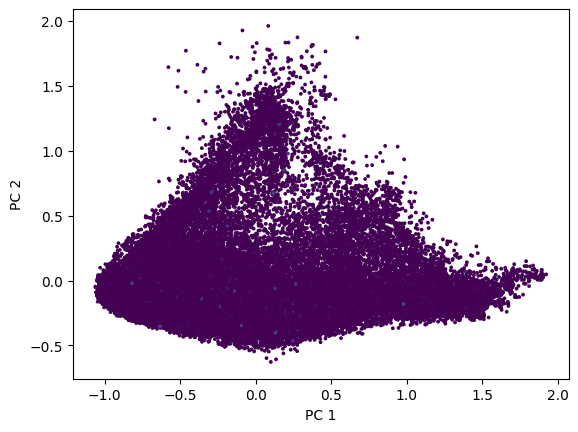

In [357]:
plot_2D(embedding[msk], labels[msk])

(-1.0, 10.0)

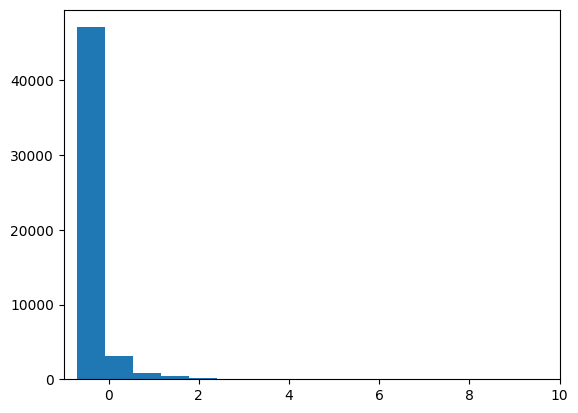

In [366]:
plt.hist(labels[msk], bins = 100)
plt.xlim(-1,10)

In [341]:
embedding.shape

(53083, 64)

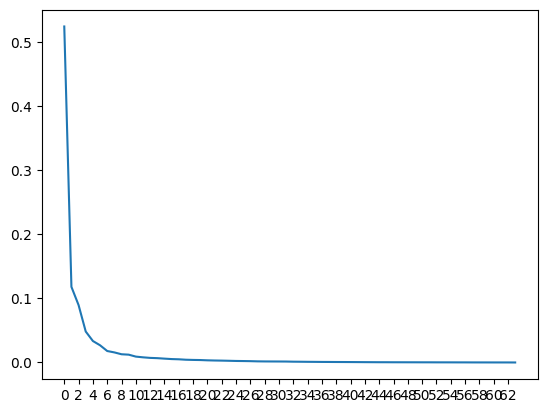

In [344]:
pca = PCA()
pca.fit(embedding[msk])
plt.plot(range(pca.n_components_), pca.explained_variance_ratio_)
plt.xticks(range(0,64,2), range(0,64,2))
plt.show()

In [374]:
X_red = pca.transform(embedding[msk])
ilabs = get_iforest_outliers(X_red, X_red, 100)

In [375]:
labels[msk].shape

(52007,)

In [376]:
embedding[msk].shape

(52007, 64)

In [378]:
X_red.shape

(52007, 64)

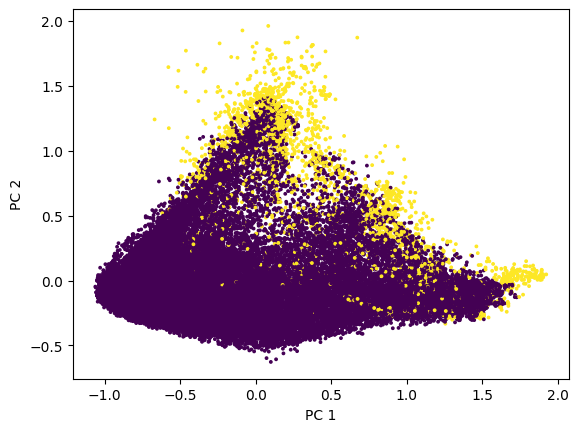

In [379]:
plot_2D(X_red, ilabs)

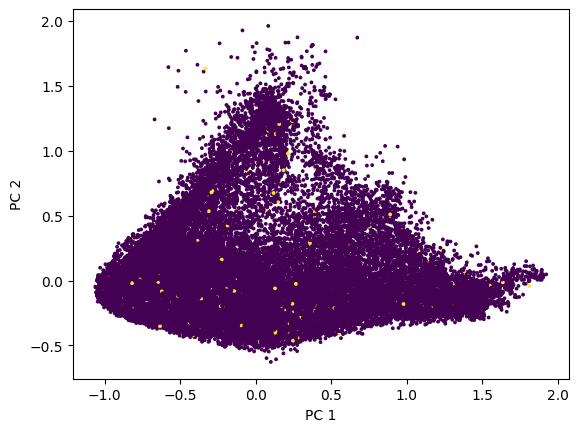

In [380]:
plot_2D(X_red, labels[msk] > 2)

In [ ]:
# dimred / feature selection
# DBSCAN